# Homework 2
## Part 2 (60 points total)

In this part, you will build a convolutional neural network (aka ConvNet or CNN) to solve yet another image classification problem: the Tiny ImageNet dataset (200 classes, 100K training images, 10K validation images). Try to achieve as high accuracy as possible.

This exercise is close to what people do in real life. No toy architectures this time. **Unlike in part 1**, you are now free to use the full power of PyTorch and its submodules.

## Grading

* 11 points for the report.
* 5 points for using an **interactive** (please don't reinvent the wheel with `plt.plot`) tool for viewing progress, for example TensorBoard.
* 9 points for a network that gets above 25% accuracy on the private **test** set.
* Up to 35 points for accuracy up to 50%, issued linearly (i.e. 0 points for 25%, 7 points for 30%, 21 points for 40%, 35 points for $\geq$50%.

## Grading Explained

* *Private test set*: it's a part of the dataset like the validation set, but for which the ground truth labels are known only to us (you won't be able to evaluate your model on it). When grading, we will compute test accuracy by running your code that computes val accuracy, but having replaced the images in `'val/'` with the test set.
* *Submitting a neural net*:
  * **<font color="red">Wrong checkpoint submission = zero points for accuracy. Be careful!</font>**
  * After you've trained your network, [save weights](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html) to "*checkpoint.pth*" with `model.state_dict()` and `torch.save()`.
  * Set `DO_TRAIN = False`, click "Restart and Run All" and make sure that your validation accuracy is computed correctly.
  * Compute the MD5 checksum for "*checkpoint.pth*" (e.g. run `!md5sum checkpoint.pth`) and paste it into "*part2_solution.py*" (`get_checkpoint_metadata()`). You'll be penalized if this checksum doesn't match your submitted file.
  * Upload "*checkpoint.pth*" to Google Drive, copy the view-only link to it and paste it into "*part2_solution.py*" as well.
* *Report*: PDF, free form; rough list of points to touch upon:
  * Your history of tweaks and improvements. How you started, what you searched. (*I have analyzed these and those conference papers/sources/blog posts. I tried this and that to adapt them to my problem. ...*)
  * Which network architectures have you tried? Which of them didn't work, and can you guess why? What is the final one and why?
  * Same for the training method (batch size, optimization algorithm, number of iterations, ...): which and why?
  * Same for anti-overfitting (regularization) techniques. Which ones have you tried? What were their effects, and can you guess why?
  * **Most importantly**: deep learning insights you gained. Can you give several examples of how *exactly* experience from this exercise will affect you training your future neural nets? (tricks, heuristics, conclusions, observations)
  * **List all sources of code**.
* *Progress viewing tool*: support the report with screenshots of accuracy and loss plots (training and validation) over time.

## Restrictions

* No pretrained networks.
* Don't enlarge images (e.g. don't resize them to $224 \times 224$ or $256 \times 256$).

## Tips

* **One change at a time**: don't test several new things at once (unless you are super confident that they will work). Train a model, introduce one change, train again.
* Google a lot: try to reinvent as few wheels as possible (unlike in part 1 of this assignment). Harvest inspiration from PyTorch recipes, from GitHub, from blogs...
* Use GPU.
* Regularization is very important: L2, batch normalization, dropout, data augmentation...
* Pay much attention to accuracy and loss graphs (e.g. in TensorBoard). Track failures early, stop bad experiments early.
* 2-3 hours of training (in Colab) should be enough for most models, maybe 4-6 hours if you're experimenting.
* Save checkpoints every so often in case things go wrong (optimization diverges, Colab disconnects...).
* Don't use too large batches, they can be slow and memory-hungry. This is true for inference too.
* Also don't forget to use `torch.no_grad()` and `.eval()` during inference.

In [1]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    # AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2021 -- Home Assignment 2")
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Colab Notebooks/Deep Learning (Term 4)/hw2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Mounted at /content/drive


In [2]:
# Imports

# Your solution
%load_ext autoreload
%autoreload 1

%aimport part2_solution

In [11]:
# If `True`, will train the model from scratch and validate it.
# If `False`, instead of training will load weights from './checkpoint.pth'.
# When grading, we will test both cases.
DO_TRAIN = True

In [12]:
# Put training and validation images in `./tiny-imagenet-200/train` and `./tiny-imagenet-200/val`:
if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
    import zipfile
    with zipfile.ZipFile(AUX_DATA_ROOT / 'tiny-imagenet-2020.zip', 'r') as archive:
        archive.extractall()

In [13]:
# Initialize dataloaders
train_dataloader = part2_solution.get_dataloader("./tiny-imagenet-200/", 'train')
val_dataloader   = part2_solution.get_dataloader("./tiny-imagenet-200/", 'val')

# Initialize the raw model
model = part2_solution.get_model()

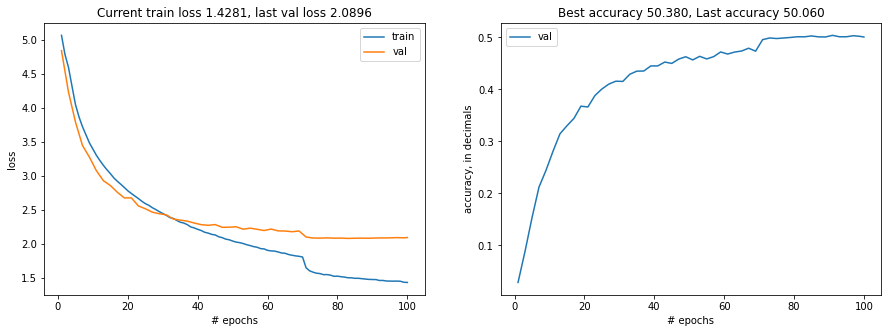

In [14]:
if DO_TRAIN:
    # Train from scratch
    optimizer = part2_solution.get_optimizer(model)
    part2_solution.train_on_tinyimagenet(train_dataloader, val_dataloader, model, optimizer)
else:
    # Load from disk
    part2_solution.load_weights(model, "./checkpoint.pth")

In [8]:
# Classify some validation samples
example_batch, example_batch_labels = next(iter(val_dataloader))
_, example_predicted_labels = part2_solution.predict(model, example_batch).max(1)

print("Predicted class / Ground truth class")
for predicted, gt in list(zip(example_predicted_labels, example_batch_labels))[:15]:
    print("{:03d} / {:03d}".format(predicted, gt))

Predicted class / Ground truth class
000 / 000
000 / 000
000 / 000
000 / 000
000 / 000
104 / 000
000 / 000
000 / 000
000 / 000
000 / 000
000 / 000
000 / 000
000 / 000
000 / 000
000 / 000


In [9]:
# Print validation accuracy
val_accuracy, _ = part2_solution.validate(val_dataloader, model)
val_accuracy *= 100
assert 1.5 <= val_accuracy <= 100.0
print("Validation accuracy: %.2f%%" % val_accuracy)


Validation accuracy: 51.12%


In [10]:
md5_checksum, google_drive_link = part2_solution.get_checkpoint_metadata()
print(f"Claimed MD5 checksum: {md5_checksum}")
print("Real MD5 checksum:")
!md5sum checkpoint.pth

Claimed MD5 checksum: 7d4bc46dfb2abd5255d26a52e01905e4
Real MD5 checksum:
7d4bc46dfb2abd5255d26a52e01905e4  checkpoint.pth
